In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import r2_score
import matplotlib.ticker as mticker
from lmfit.models import PowerLawModel

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})

In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a*x**b
        
        return y_fit-y

def func_powerlaw(x, a, b):
        return a*x**b

def calc_rsquared(x, y, amplitude, exponent):
    yhat = func_powerlaw(x, amplitude, exponent)

    return r2_score(y, yhat)

In [3]:
dataBase_path = r'./'
dataBase_file = r'UUVCOT_database.xlsx'
biological_file = r'biological_COT_Data.ods'

In [4]:
data_path = Path(dataBase_path, dataBase_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')
liftDF = pd.read_excel(data_path, sheet_name="LiftBased")

data_path = Path(dataBase_path, biological_file)
bioDF = pd.read_excel(data_path, sheet_name='Videler and Nolet')
bio_kinematics = pd.read_excel(data_path, sheet_name='Videler Kinematic')
bioDF = bioDF.sort_values('Weight [kg]')

In [5]:
conv_cot = convDF[convDF['COTopt [J/m]'].notnull()]
bcf_cot = bcfDF[bcfDF['COTopt [J/m]'].notnull()]
mpf_cot = mpfDF[mpfDF['COTopt [J/m]'].notnull()]
lift_cot = liftDF[liftDF['COTopt [J/m]'].notnull()]

# sort the column values in ascending order
conv_cot = conv_cot.sort_values('Weight [kg]')
bcf_cot = bcf_cot.sort_values('Weight [kg]')
mpf_cot = mpf_cot.sort_values('Weight [kg]')
lift_cot = lift_cot.sort_values('Weight [kg]')

# drop all rows with nan values
conv_cot.dropna(subset=['Weight [kg]'], inplace=True)
bcf_cot.dropna(subset=['Weight [kg]'], inplace=True)
mpf_cot.dropna(subset=['Weight [kg]'], inplace=True)
lift_cot.dropna(subset=['Weight [kg]'], inplace=True)

In [6]:
# break up the data frame into perspective locomotion modes
bio_modes = bioDF['Mode'].unique()
conv_modes = conv_cot['Locomotion'].unique()
bcf_modes = bcf_cot['Locomotion'].unique()
mpf_modes = mpf_cot['Locomotion'].unique()
lift_modes = lift_cot['Locomotion'].unique()

bio_dfs = [bioDF[bioDF['Mode']==mode] for mode in bio_modes]
conv_dfs = [conv_cot[conv_cot['Locomotion']==mode] for mode in conv_modes]
bcf_dfs = [bcf_cot[bcf_cot['Locomotion']==mode] for mode in bcf_modes]
mpf_dfs = [mpf_cot[mpf_cot['Locomotion']==mode] for mode in mpf_modes]
lift_dfs = [lift_cot[lift_cot['Locomotion']==mode] for mode in lift_modes]

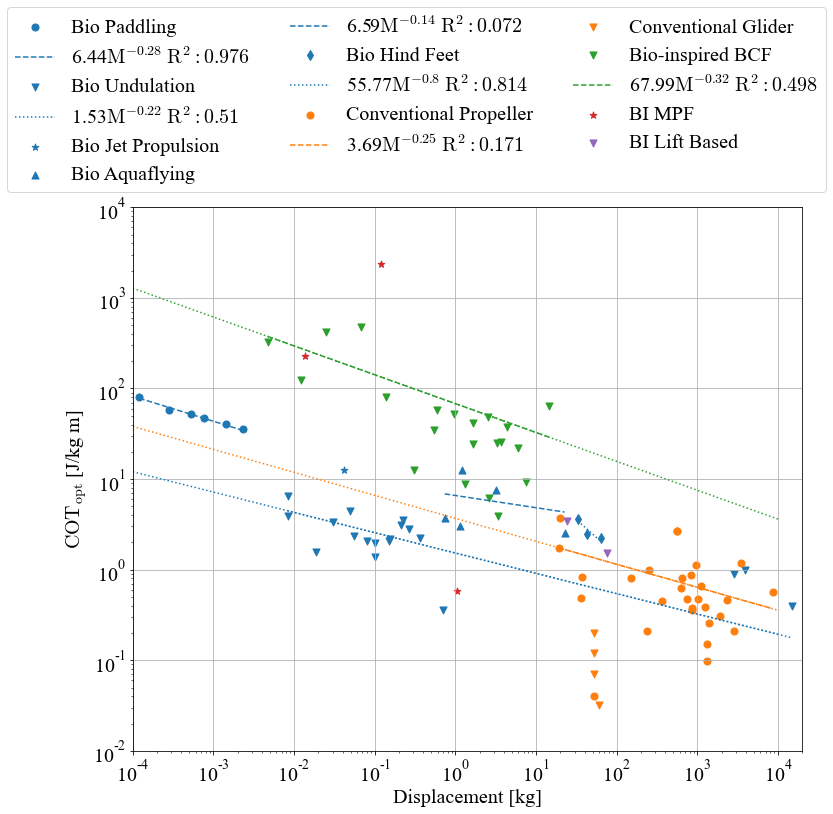

In [12]:
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']
linestyles = ['dashed','dotted','dashdot','dashed','dotted']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e-4, 1e4, 50)
for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Weight [kg]'])
        
        if mode == 'Jet Propulsion':
                ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J/kgm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-2.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/kgm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/kgm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

                ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax1.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax1.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')        
        else: 
                pars = model.guess(data['COTopt [J/kgm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-2.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/kgm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/kgm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax1.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')           

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J/kgm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-2.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/kgm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/kgm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax1.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax1.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

col = 'C2'
        # perform fits for data
data = pd.concat(bcf_dfs)
data = data.sort_values(by=['Weight [kg]'])
pars = model.guess(data['COTopt [J/kgm]'].values, x=data['Weight [kg]'].values)
pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
pars['p_exponent'].set(value=-0.5, min=-0.75, max=0.001)

fit = model.fit(data['COTopt [J/kgm]'], pars, x=data['Weight [kg]'])

r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/kgm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

ax1.scatter(data['Weight [kg]'], data['COTopt [J/kgm]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax1.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col+'--',
        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        + str(np.round(r_squared, 3)) + '}$')
ax1.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax1.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/kgm]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax1.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J/kgm]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax1.set_xlabel('Displacement [kg]')
ax1.set_ylabel('$\mathrm{COT_{opt}}$ [J/kg m]')
ax1.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 1.01))

ax1.set_xlim([1e-4, 2e4])
ax1.set_ylim([1e-2, 1e4])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid()
fig1.savefig('cot_j-kgm.pdf', facecolor='w', dpi=300, bbox_inches='tight')

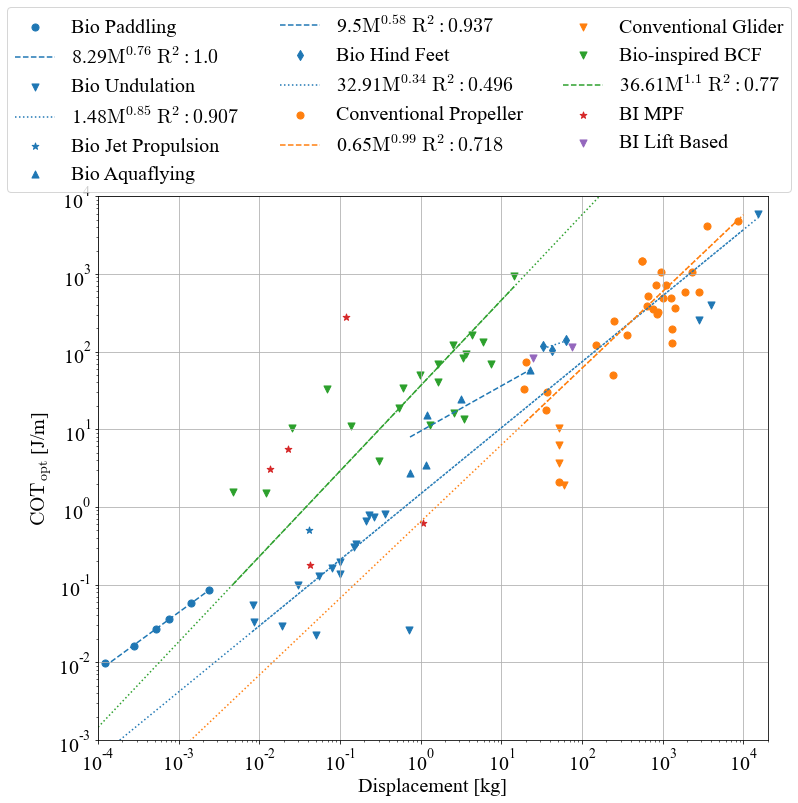

In [13]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e-4, 1e4, 50)
for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Weight [kg]'])
        
        if mode == 'Jet Propulsion':
                ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J/m]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=20.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=0.85)
                
                fit = model.fit(data['COTopt [J/m]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/m]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

                ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')           
                ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')           
        else:  
                pars = model.guess(data['COTopt [J/m]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)
                
                fit = model.fit(data['COTopt [J/m]'].values, pars, x=data['Weight [kg]'].values)

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/m]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2))  + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')           

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J/m]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)
                
                fit = model.fit(data['COTopt [J/m]'].values, pars, x=data['Weight [kg]'].values)

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/m]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

col = 'C2'
# perform fits for data
data = pd.concat(bcf_dfs)
data = data.sort_values(by=['Weight [kg]'])

pars = model.guess(data['COTopt [J/m]'].values, x=data['Weight [kg]'].values)
pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
pars['p_exponent'].set(value=0.5, min=0.001, max=1.1)

fit = model.fit(data['COTopt [J/m]'], pars, x=data['Weight [kg]'])

r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/m]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

ax2.scatter(data['Weight [kg]'], data['COTopt [J/m]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax2.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        + str(np.round(r_squared, 3)) + '}$')
ax2.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax2.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J/m]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax2.set_xlabel('Displacement [kg]')
ax2.set_ylabel('$\mathrm{COT_{opt}}$ [J/m]')
ax2.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 0.99))

ax2.set_xlim([1e-4, 2e4])
ax2.set_ylim([1e-3, 1e4])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid()
fig2.savefig('cot_j-m.pdf', facecolor='w', dpi=300, bbox_inches='tight')

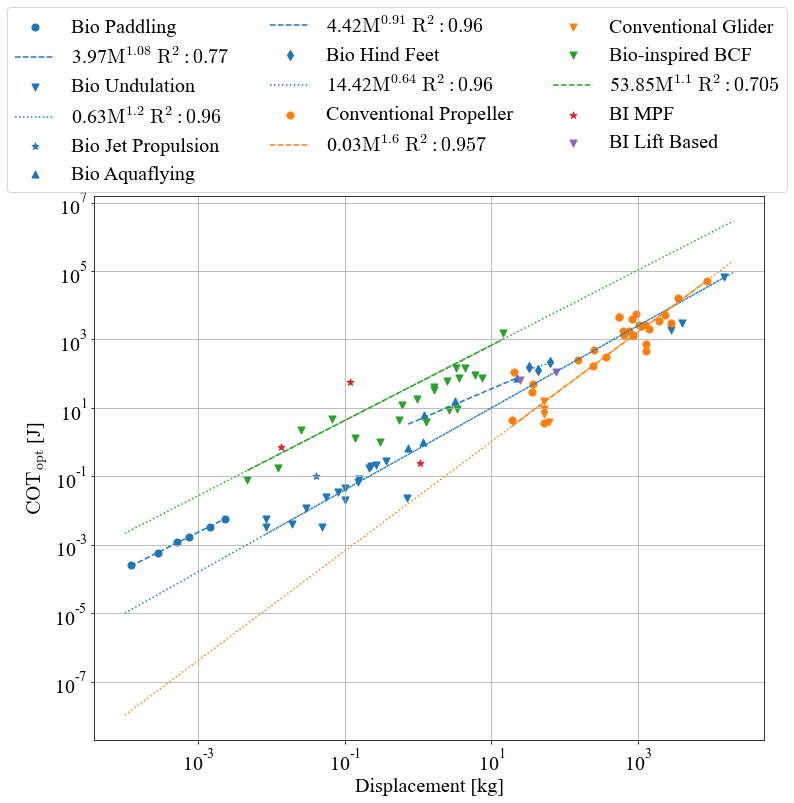

In [14]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e-4, 2e4, 50)

for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Weight [kg]'])
        
        if mode == 'Jet Propulsion':
                ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=20.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=1.2)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Weight [kg]'].values)

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

                ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax3.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + '{:.2}'.format(r_squared) + '}$')
                ax3.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else: 
                pars = model.guess(data['COTopt [J]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=500.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=2.0)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Weight [kg]'].values)
                
                ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax3.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + '{:.2}'.format(r_squared) + '}$')           

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        amplitude = 0.03
        exponent = 1.6
        data = conv_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.0001, max=20.0)
                pars['p_exponent'].set(value=0.5, min=0.001, max=5.0)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Weight [kg]'].values)

                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax3.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax3.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

col = 'C2'
# perform fits for data
data = pd.concat(bcf_dfs)
data = data.sort_values(by=['Weight [kg]'])
pars = model.guess(data['COTopt [J]'].values, x=data['Weight [kg]'].values)
pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
pars['p_exponent'].set(value=0.5, min=0.001, max=1.1)

fit = model.fit(data['COTopt [J]'], pars, x=data['Weight [kg]'])

r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

ax3.scatter(data['Weight [kg]'], data['COTopt [J]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax3.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        + str(np.round(r_squared, 3)) + '}$')
ax3.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax3.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax3.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax3.set_xlabel('Displacement [kg]')
ax3.set_ylabel('$\mathrm{COT_{opt}}$ [J]')
ax3.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 0.99))

# ax3.set_xlim([1e-4, 2e4])
# ax3.set_ylim([1e-4, 1e5])
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.grid()
fig3.savefig('cot_j.pdf', facecolor='w', dpi=300, bbox_inches='tight')

In [15]:
# sort the column values in ascending order
conv_cot = conv_cot.sort_values('Re')
bcf_cot = bcf_cot.sort_values('Re')
mpf_cot = mpf_cot.sort_values('Re')
lift_cot = lift_cot.sort_values('Re')

# drop all rows with nan values
conv_cot.dropna(subset=['Re'], inplace=True)
bcf_cot.dropna(subset=['Re'], inplace=True)
mpf_cot.dropna(subset=['Re'], inplace=True)
lift_cot.dropna(subset=['Re'], inplace=True)

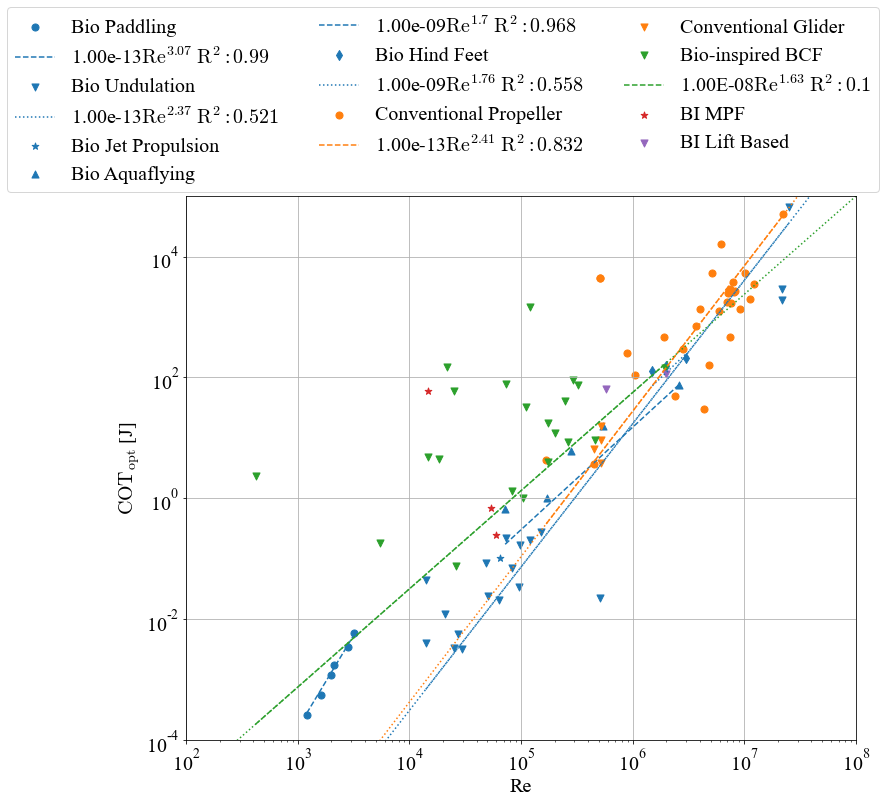

In [16]:
fig4, ax4 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e2, 1e8, 50)

for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Re'])
        
        if mode == 'Jet Propulsion':
                ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=1e-12, min=1e-13, max=1e-8)
                pars['p_exponent'].set(value=2.25, min=1.0, max=5.0)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

                ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax4.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.2e}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax4.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                pars = model.guess(data['COTopt [J]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=1e-12, min=1e-13, max=1e-9)
                pars['p_exponent'].set(value=2.25, min=1.0, max=5.0)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax4.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label='{:.2e}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                # ax4.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')          

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Re'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=1e-12, min=1e-13, max=1e-8)
                pars['p_exponent'].set(value=2.25, min=1.0, max=5.0)
                
                fit = model.fit(data['COTopt [J]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax4.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.2e}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax4.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

        col = 'C2'
        # perform fits for data
data = pd.concat(bcf_dfs)
data = data.sort_values(by=['Re'])
pars = model.guess(data['COTopt [J]'].values, x=data['Re'].values)
pars['p_amplitude'].set(value=1e-12, min=1e-13, max=1e-8)
pars['p_exponent'].set(value=2.25, min=1.0, max=5.0)

fit = model.fit(data['COTopt [J]'].values, pars, x=data['Re'].values)

r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

ax4.scatter(data['Re'], data['COTopt [J]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax4.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, col + '--', 
        label='{:.2E}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        + str(np.round(r_squared, 3)) + '}$')
ax4.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax4.scatter(mpf_cot['Re'], mpf_cot['COTopt [J]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax4.scatter(lift_cot['Re'], lift_cot['COTopt [J]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax4.set_xlabel('Re')
ax4.set_ylabel('$\mathrm{COT_{opt}}$ [J]')
ax4.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 0.99))

ax4.set_xlim([1e2, 1e8])
ax4.set_ylim([1e-4, 1e5])
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.grid()
fig4.savefig('cot_j_Re.pdf', facecolor='w', dpi=300, bbox_inches='tight')

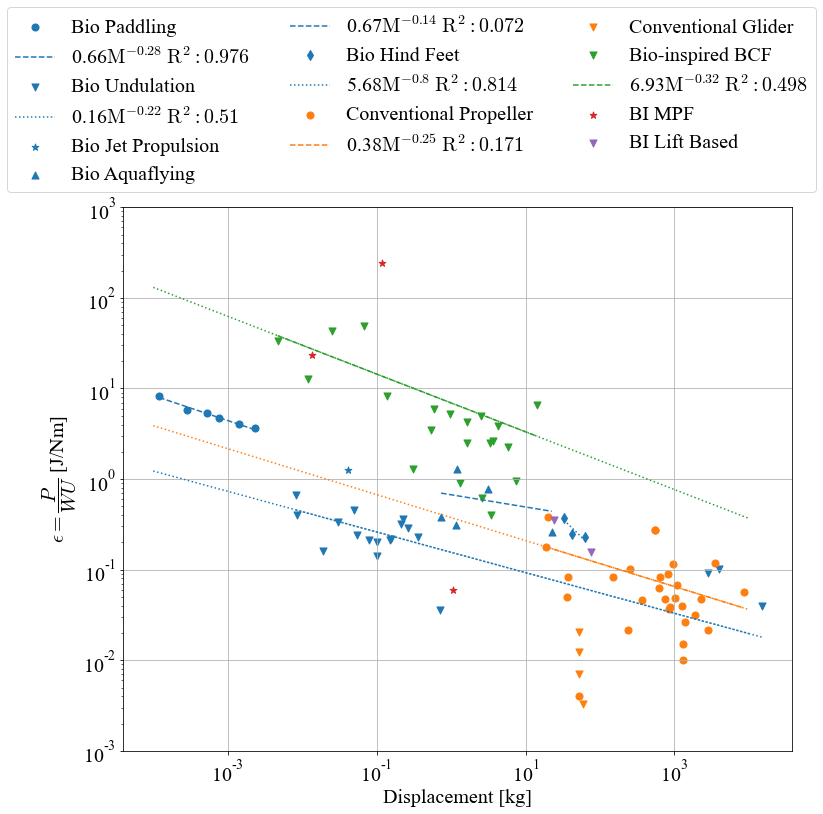

In [17]:
fig5, ax5 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e-4, 1e4, 50)
for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Weight [kg]'])
        
        if mode == 'Jet Propulsion':
                ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-2.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

                ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax5.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax5.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')        
        else: 
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-2.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax5.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')           

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Weight [kg]'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Weight [kg]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-5.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Weight [kg]'].values)
                
                r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)
                
                ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax5.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col,
                        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax5.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

col = 'C2'
# perform fits for data
data = pd.concat(bcf_dfs)
data = data.sort_values(by=['Weight [kg]'])
pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Weight [kg]'].values)
pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
pars['p_exponent'].set(value=-0.5, min=-0.75, max=0.001)

fit = model.fit(data['COTopt [J/Nm]'], pars, x=data['Weight [kg]'])

r_squared = calc_rsquared(data['Weight [kg]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

ax5.scatter(data['Weight [kg]'], data['COTopt [J/Nm]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax5.plot(data['Weight [kg]'], fit.params['p_amplitude'].value*data['Weight [kg]'].values**fit.params['p_exponent'].value, col + '--', 
        label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
        + str(np.round(r_squared, 3)) + '}$')
ax5.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')

ax5.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/Nm]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax5.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J/Nm]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax5.set_xlabel('Displacement [kg]')
ax5.set_ylabel('$\mathrm{\epsilon} = \dfrac{P}{WU}$ [J/Nm]')
ax5.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 1.01))

# ax5.set_xlim([1e-4, 2e4])
ax5.set_ylim([1e-3, 1e3])
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.grid()
fig5.savefig('cot_j-Nm.pdf', facecolor='w', dpi=300, bbox_inches='tight')

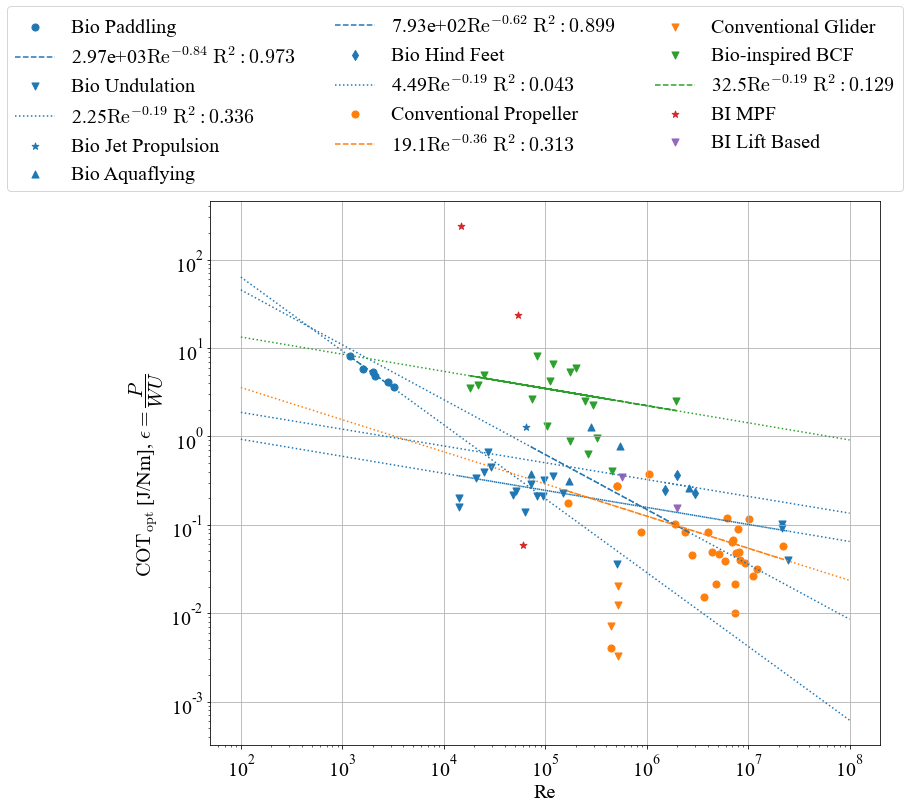

In [18]:
fig6, ax6 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(1e2, 1e8, 50)

for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Re'])
        
        if mode == 'Jet Propulsion':
                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=6, min=0.0001, max=10000)
                pars['p_exponent'].set(value=-0.5, min=-5.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax6.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax6.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        elif mode == 'Aquaflying':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=100, min=500, max=10000)
                pars['p_exponent'].set(value=-0.5, min=-5.0, max=-0.4)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax6.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax6.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=6, min=0.0001, max=10000)
                pars['p_exponent'].set(value=-0.5, min=-5.0, max=-0.19)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax6.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax6.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')          

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Re'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Re'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=10000)
                pars['p_exponent'].set(value=-0.5, min=-5.0, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Re'].values)

                r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax6.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, linestyle=linestyles[i], color=col, 
                        label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                        + str(np.round(r_squared, 3)) + '}$')
                ax6.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

col = 'C2'
data = pd.concat(bcf_dfs)
data.sort_values(by=['Re'])
data = data[data['Re'] >= 1e3]
data = data[data['COTopt [J/Nm]'] <= 10]

pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Re'].values)
pars['p_amplitude'].set(value=6, min=0.001, max=1000)
pars['p_exponent'].set(value=-0.75, min=-5.0, max=0.01)

fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Re'].values)

r_squared = np.abs(calc_rsquared(data['Re'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

ax6.scatter(data['Re'], data['COTopt [J/Nm]'], marker=markers[i], color='C2', s=marker_size, label='Bio-inspired BCF')
ax6.plot(data['Re'], fit.params['p_amplitude'].value*data['Re'].values**fit.params['p_exponent'].value, col + '--', 
label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{Re^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
+ str(np.round(r_squared, 3)) + '}$')
ax6.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')


ax6.scatter(mpf_cot['Re'], mpf_cot['COTopt [J/Nm]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax6.scatter(lift_cot['Re'], lift_cot['COTopt [J/Nm]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax6.set_xlabel('Re')
ax6.set_ylabel('$\mathrm{COT_{opt}}$ [J/Nm], $\epsilon = \dfrac{P}{WU}$')
ax6.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 1.00))

#ax6.set_xlim([0, 1e7])
#ax6.set_ylim([0, 50])
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.grid()
fig6.savefig('cot_j-Nm_Re.pdf', facecolor='w', dpi=300, bbox_inches='tight')

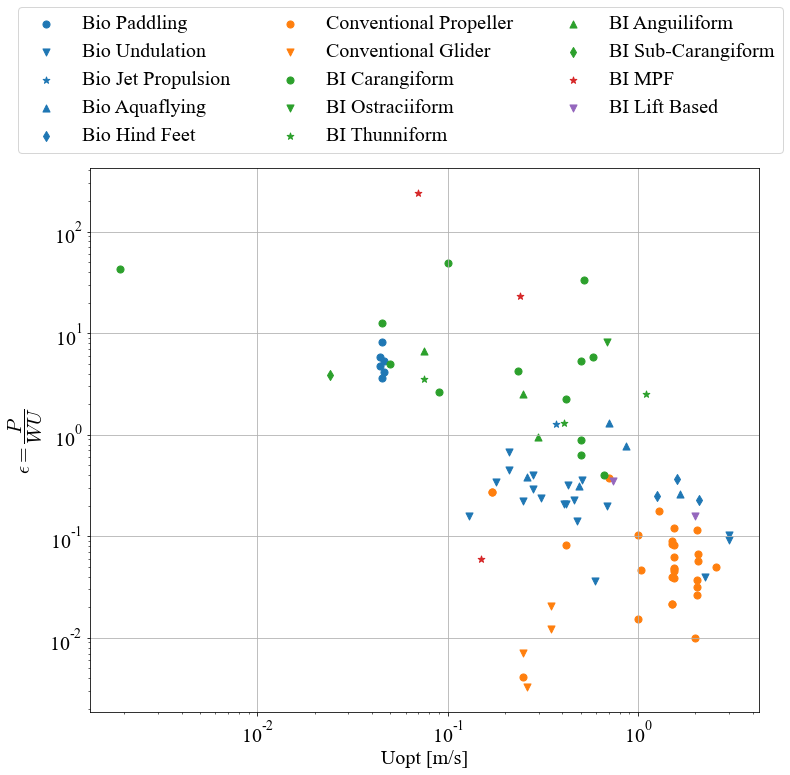

In [19]:
fig7, ax7 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']

model = PowerLawModel(prefix='p_')
dx = np.linspace(5e-3, 1e1, 50)

for i, mode in enumerate(bio_modes):
        col = 'C0'
        data = bio_dfs[i].sort_values(by=['Uopt [m/s]'])
        
        if mode == 'Jet Propulsion':
                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
        elif mode == 'Undulation':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Uopt [m/s]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-0.75, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Uopt [m/s]'].values)

                r_squared = np.abs(calc_rsquared(data['Uopt [m/s]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                # ax7.plot(data['Uopt [m/s]'], fit.params['p_amplitude'].value*data['Uopt [m/s]'].values**fit.params['p_exponent'].value, col + '--', 
                #         label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                #         + str(np.round(r_squared, 4)) + '}$')
                # ax7.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Uopt [m/s]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-0.75, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Uopt [m/s]'].values)

                r_squared = np.abs(calc_rsquared(data['Uopt [m/s]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                # ax7.plot(data['Uopt [m/s]'], fit.params['p_amplitude'].value*data['Uopt [m/s]'].values**fit.params['p_exponent'].value, col + '--', 
                #         label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                #         + str(np.round(r_squared, 4)) + '}$')
                # ax7.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')          

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        data = conv_dfs[i].sort_values(by=['Re'])
        if mode == 'Propeller':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Uopt [m/s]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=100.0)
                pars['p_exponent'].set(value=-0.5, min=-0.75, max=0.001)
                
                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Uopt [m/s]'].values)

                r_squared = np.abs(calc_rsquared(data['Uopt [m/s]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))
                
                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                # ax7.plot(data['Uopt [m/s]'], fit.params['p_amplitude'].value*data['Uopt [m/s]'].values**fit.params['p_exponent'].value, col + '--', 
                #         label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                #         + str(np.round(r_squared, 4)) + '}$')
                # ax7.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

for i, mode in enumerate(bcf_modes):
        col = 'C2'
        # perform fits for data
        data = bcf_dfs[i].sort_values(by=['Uopt [m/s]'])
        if mode == 'Carangiform':
                pars = model.guess(data['COTopt [J/Nm]'].values, x=data['Uopt [m/s]'].values)
                pars['p_amplitude'].set(value=6, min=0.001, max=5.0)
                pars['p_exponent'].set(value=-0.5, min=-1.0, max=-0.70)

                fit = model.fit(data['COTopt [J/Nm]'].values, pars, x=data['Uopt [m/s]'].values)
                
                r_squared = np.abs(calc_rsquared(data['Uopt [m/s]'].values, data['COTopt [J/Nm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value))

                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color='C2', s=marker_size, label='BI ' + mode)
                # ax7.plot(data['Uopt [m/s]'], fit.params['p_amplitude'].value*data['Uopt [m/s]'].values**fit.params['p_exponent'].value, col + '--', 
                #         label='{:.3}'.format(fit.params['p_amplitude'].value) + '$\mathrm{M^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;R^2: ' 
                #         + str(np.round(r_squared, 4)) + '}$')
                # ax7.plot(dx, fit.params['p_amplitude'].value*dx**fit.params['p_exponent'].value, col + ':')
        else:
                ax7.scatter(data['Uopt [m/s]'], data['COTopt [J/Nm]'], marker=markers[i], color='C2', s=marker_size, label='BI ' + mode)

ax7.scatter(mpf_cot['Uopt [m/s]'], mpf_cot['COTopt [J/Nm]'], marker='*', color='C3', s=marker_size, label='BI MPF')
ax7.scatter(lift_cot['Uopt [m/s]'], lift_cot['COTopt [J/Nm]'], marker='v', color='C4', s=marker_size, label='BI Lift Based')

ax7.set_xlabel('Uopt [m/s]')
ax7.set_ylabel('$\mathrm{\epsilon} = \dfrac{P}{WU}$')
ax7.legend(ncol=3, loc=4, bbox_to_anchor=(1.05, 1.01))

# ax6.set_xlim([1e2, 1e8])
# ax6.set_ylim([1e-4, 1e5])
ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.grid()
#fig7.savefig('e_j_Re.pdf', facecolor='w', dpi=300, bbox_inches='tight')